## Семинар 3 "Определение ключевых точек лица"

# Подготовительная задача 1

Сделать из линейной регрессии nn.sequental двухслойную сеть

# Подготовительная задача 2

Используя структуру сети Sequental в pytorch реализовать и обучить классификатор цифр из MNIST
(повторить первый и второй пункты из прошлого задания )

## Задание

Используя датасет из архива решите задачу регрессии для поиска 68-ми ключевых точек лица. 

Для обучения и валидации используйте изображения и разметку из папок train и test соответственно.

Попробуйте сети глубины 1 и 2 и разные активации (ELU, RELU и sigmoid).

Image name: 10.jpeg
Landmarks shape: (68, 2)
First 4 Landmarks: [[  4.  34.]
 [  5.  44.]
 [  6.  54.]
 [  9.  64.]]


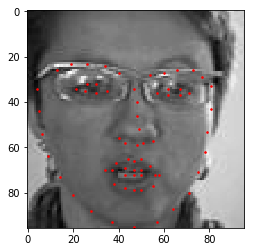

In [1]:
%matplotlib inline
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

landmarks_frame = pd.read_csv('dataset/train/face_landmarks.csv')

n = 2
img_name = landmarks_frame.ix[n, 0]
landmarks = landmarks_frame.ix[n, 1:].as_matrix().astype('float')
landmarks = landmarks.reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    
    plt.imshow(image, cmap='gray')
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  

plt.figure()
show_landmarks(io.imread(os.path.join('dataset/train/', img_name)),
               landmarks)
plt.show()

In [2]:
class FaceLandmarksDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.ix[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.ix[idx, 1:].as_matrix().astype('float')
        landmarks = landmarks.reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [9]:
class Normalize(object):
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        return {'image': image, 'landmarks': landmarks}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
    
        image = image.reshape((1, 96, 96))
        return {'image': torch.from_numpy(image.astype('float32')),
                'landmarks': torch.from_numpy(landmarks)}


transformed_dataset = FaceLandmarksDataset(csv_file='dataset/train/face_landmarks.csv',
                                    root_dir='dataset/train/',
                                    transform=transforms.Compose([
#                                                Normalize(),
                                               ToTensor()
                                           ]))
transformed_dataset_test = FaceLandmarksDataset(csv_file='dataset/test/face_landmarks.csv',
                                    root_dir='dataset/test/',
                                    transform=transforms.Compose([
#                                                Normalize(),
                                               ToTensor()
                                           ]))

dataloader_demo = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=1)
dataloader = DataLoader(transformed_dataset, batch_size=4096,
                        shuffle=True, num_workers=1)
dataloader_test = DataLoader(transformed_dataset_test, batch_size=4,
                        shuffle=True, num_workers=1)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    
    print(landmarks_batch.shape)

    grid = utils.make_grid(images_batch)
    
#     plt.imshow(images_batch[0,0].numpy(), cmap='gray')
    plt.imshow(grid.numpy()[0], cmap='gray')

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * (im_size + 2),
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

In [20]:
from torch.autograd import Variable

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
#         self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=7)
#         self.conv2 = torch.nn.Conv2d(32, 96, kernel_size=7)
#         self.fc1 = torch.nn.Linear(64 * 96, 256)
#         self.fc2 = torch.nn.Linear(256, 136)
        self.fc1 = torch.nn.Linear(96 * 96, 136, bias=True)
#         self.fc2 = torch.nn.Linear(256, 136)

    def forward(self, x):
#         x = torch.nn.functional.relu(torch.nn.functional.max_pool2d(self.conv1(x), 3))
#         x = torch.nn.functional.relu(torch.nn.functional.max_pool2d(self.conv2(x), 3))
#         x = x.view(-1, 64 * 96)
        x = x.view(-1, 96 * 96) / 256.0e2
        x = self.fc1(x)
#         x = torch.nn.functional.relu(x)
#         x = self.fc2(x)
#         x = torch.nn.functional.elu(x)
#         x = self.fc2(x)
        x = x.view(-1, 68, 2) * 96.0
        return x
model = Net()

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [36]:
def train(epoch):
    model.train()
    for batch_idx, (data) in enumerate(dataloader):
        data, target = Variable(data['image']), Variable(data['landmarks'])
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.mse_loss(output, target.float())
        loss.backward()
        optimizer.step()
        if batch_idx % 1 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dataloader.dataset),
                100. * batch_idx / len(dataloader), loss.data[0]))

for epoch in range(1, 30):
    train(epoch)
#     test()

Train Epoch: 1 [0/6221 (0%)]	Loss: 12.677800
Train Epoch: 1 [2125/6221 (50%)]	Loss: 12.535010
Train Epoch: 2 [0/6221 (0%)]	Loss: 12.104558
Train Epoch: 2 [2125/6221 (50%)]	Loss: 13.407560
Train Epoch: 3 [0/6221 (0%)]	Loss: 12.408590
Train Epoch: 3 [2125/6221 (50%)]	Loss: 12.576499
Train Epoch: 4 [0/6221 (0%)]	Loss: 12.746121
Train Epoch: 4 [2125/6221 (50%)]	Loss: 11.734980
Train Epoch: 5 [0/6221 (0%)]	Loss: 12.463507
Train Epoch: 5 [2125/6221 (50%)]	Loss: 12.040080
Train Epoch: 6 [0/6221 (0%)]	Loss: 12.536309
Train Epoch: 6 [2125/6221 (50%)]	Loss: 11.692619
Train Epoch: 7 [0/6221 (0%)]	Loss: 12.462362
Train Epoch: 7 [2125/6221 (50%)]	Loss: 11.599428
Train Epoch: 8 [0/6221 (0%)]	Loss: 11.947197
Train Epoch: 8 [2125/6221 (50%)]	Loss: 12.380857
Train Epoch: 9 [0/6221 (0%)]	Loss: 11.893107
Train Epoch: 9 [2125/6221 (50%)]	Loss: 12.270475
Train Epoch: 10 [0/6221 (0%)]	Loss: 11.868953
Train Epoch: 10 [2125/6221 (50%)]	Loss: 12.118072
Train Epoch: 11 [0/6221 (0%)]	Loss: 11.365618
Train Epoch:

In [29]:
def test():
    model.eval()
    for i_batch, sample_batched in enumerate(dataloader_demo):
        print(i_batch, sample_batched['image'].size(),
              sample_batched['landmarks'].size())

        sample_batched['landmarks'] = model(Variable(sample_batched['image'])).data.view(-1,68,2)
        print(sample_batched['landmarks'].numpy().shape)
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

0 torch.Size([4, 1, 96, 96]) torch.Size([4, 68, 2])
(4, 68, 2)
torch.Size([4, 68, 2])


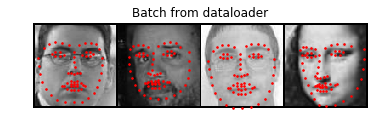

0 torch.Size([4, 1, 96, 96]) torch.Size([4, 68, 2])
(4, 68, 2)
torch.Size([4, 68, 2])


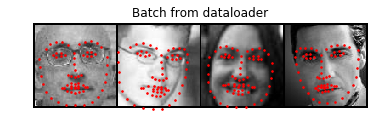

0 torch.Size([4, 1, 96, 96]) torch.Size([4, 68, 2])
(4, 68, 2)
torch.Size([4, 68, 2])


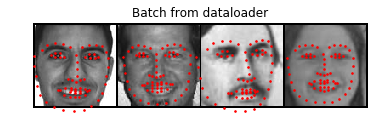

0 torch.Size([4, 1, 96, 96]) torch.Size([4, 68, 2])
(4, 68, 2)
torch.Size([4, 68, 2])


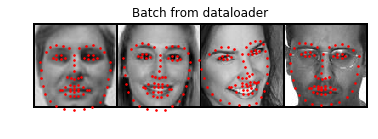

0 torch.Size([4, 1, 96, 96]) torch.Size([4, 68, 2])
(4, 68, 2)
torch.Size([4, 68, 2])


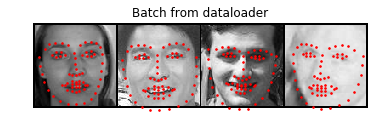

0 torch.Size([4, 1, 96, 96]) torch.Size([4, 68, 2])
(4, 68, 2)
torch.Size([4, 68, 2])


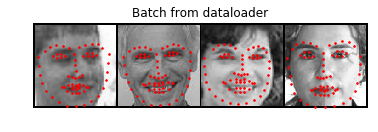

0 torch.Size([4, 1, 96, 96]) torch.Size([4, 68, 2])
(4, 68, 2)
torch.Size([4, 68, 2])


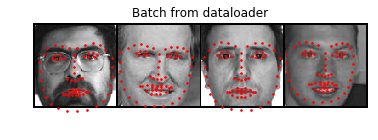

0 torch.Size([4, 1, 96, 96]) torch.Size([4, 68, 2])
(4, 68, 2)
torch.Size([4, 68, 2])


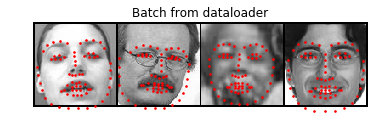

0 torch.Size([4, 1, 96, 96]) torch.Size([4, 68, 2])
(4, 68, 2)
torch.Size([4, 68, 2])


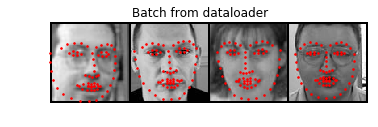

0 torch.Size([4, 1, 96, 96]) torch.Size([4, 68, 2])
(4, 68, 2)
torch.Size([4, 68, 2])


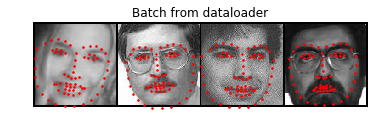

In [37]:
for _ in range(10):
    test()